<a href="https://colab.research.google.com/github/Bot2353/PID-Simulation/blob/main/%C3%9Cbung%201%20-%20Ein%20geregelter%20Ofen%20f%C3%BCr%20Fertigpizza.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

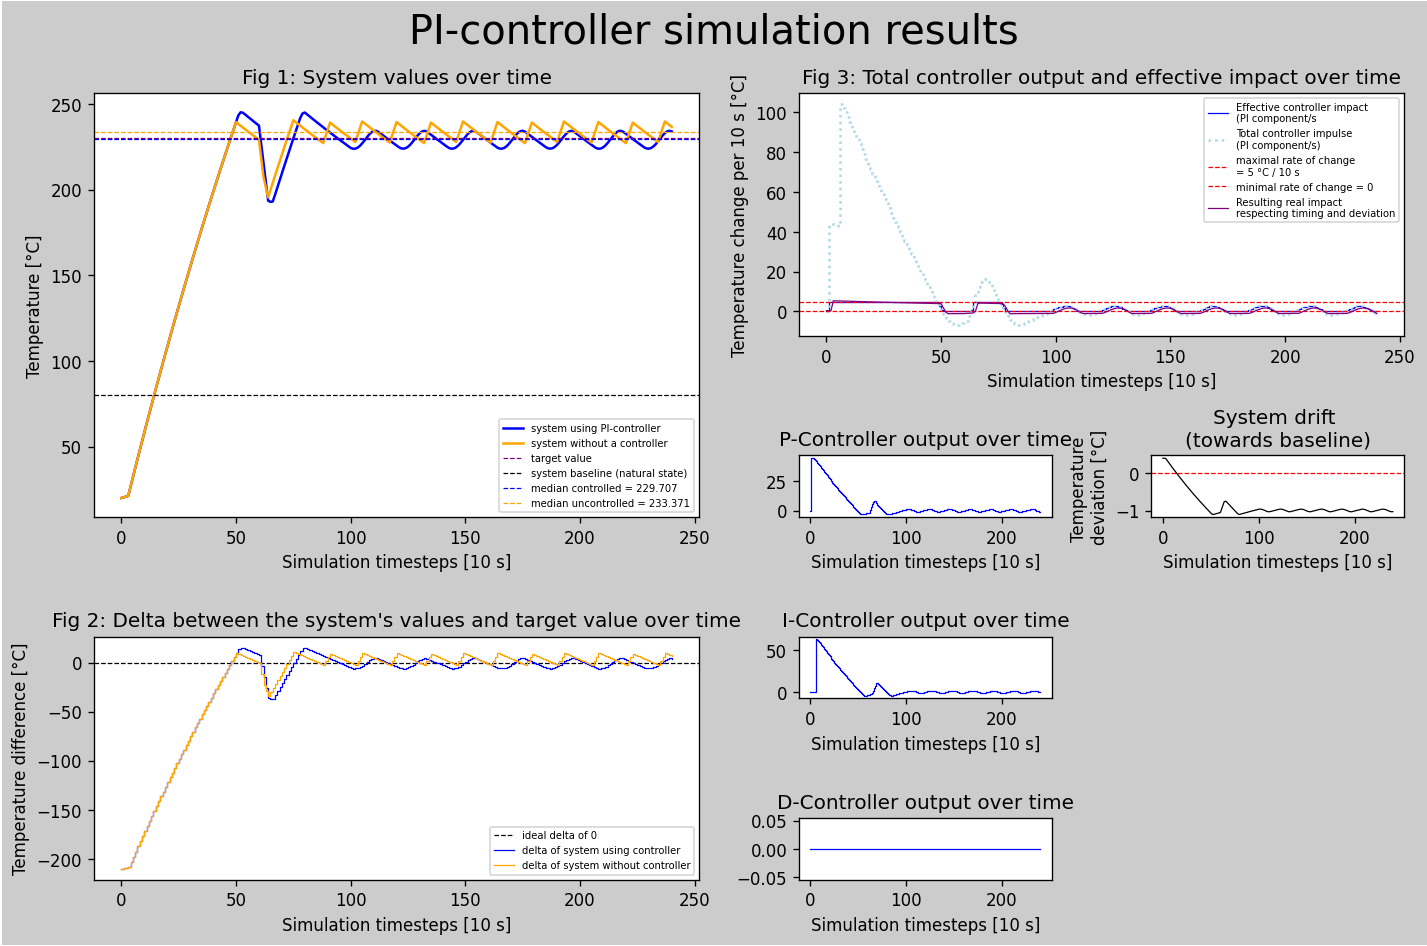

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets

# @title Übung 1 - Ein geregelter Ofen für Fertigpizza

# @markdown Ziel ist es den Ofen möglichst schnell auf 230°C zu erhitzen und diese Temperatur möglichst genau zu halten.<br><br>

# @markdown Die Simulation verläuft über 240 Zeitschritte à 10 Sekunden. <br>
# @markdown Der Regler braucht zwei Zeitschritte um eine Veränderung der Temperatur festzustellen. <br>
# @markdown Ausgaben des Reglers benötigen einen Zeitschritt um sich auf den Ofen auszuwirken. <br><br>

# @markdown Da das Heizelement des Ofens eine begrenzte Leistungsaufnahme hat, kann es den Ofen maximal mit einer Änderung von 5°C pro 10 Sekunden erhizten. <br> Der Regler kann diesen Wert überschreiten, jedoch heizt der Ofen trotzdem mit maximal 5°C pro 10 Sekunden. <br>
# @markdown Der Regler kann nur das Heizen beeinflussen, den Ofen aber nicht aktiv kühlen. Daher werden Reglerwerte unter 0 auf 0 aufgerundet. <br><br>

# @markdown Nach 10 Minuten (600 Sekunden, 60 Zeitschritte) wird die Ofentür für 40 Sekunden (4 Zeitschritte) geöffnet. Dadurch verliert der Ofen heiße Luft, die Temperatur fällt mit 10°C pro 10 Sekunden ab. <br><br>

# @markdown ###Im folgenden Bereich lässt sich der Regler einstellen: <br>
Aktiver_Regler = "PI" # @param ["P", "I", "D", "PI", "PD", "ID", "PID"] {allow-input: true}
# @markdown Bestimmt die Art des Reglers. Jede Kombination aus P, I und D ist möglich.
Faktor_für_P_Regler = 0.21 # @param {type:"slider", min: 0, max: 1, step:0.005}
Faktor_für_I_Regler = 0.075 # @param {type:"slider", min: 0, max: 1, step:0.005}
Faktor_für_D_Regler = 0.31 # @param {type:"slider", min: 0, max: 1, step:0.005}

# @markdown Einstellmöglichkeiten für fortgeschrittene.
Länge_I_Regler = 5 # @param {type:"slider", min: 2, max: 20, step:1}
Länge_D_Regler = 2 # @param {type:"slider", min: 2, max: 20, step:1}

def main():
    simulationParameters = {#General parameters
                            "simulationLength" : 241 ,                          #Simulation iterates over 241 timesteps
                            "startValue" : 20 ,                                 #Base value the system starts at (ideally the equilibrium state set by "deviationReference")
                            "targetValue" : 230 ,                               #Value the system tries to reach

                            "deviation": 1,                                     #Factor to amplify the speed at which the system will try to reach its equilibrium state set by "deviationReference"
                            "deviationReference": 80,                           #Equilibrium state the system tries to reach

                            #Units                                              #These are all just for the final graphs and better readability. They don't affect the simulation
                            "timeUnit": "10 s",
                            "unitName": "Temperature",
                            "unit": "°C",

                            #Controller parameters
                            "activeControllers" : Aktiver_Regler.lower(),       #Can be any combination of the letters P, I and D. Defines which controller components are evaluated. All others are set to 0

                            "pFactor" : Faktor_für_P_Regler ,
                            "iFactor" : Faktor_für_I_Regler , "iLength" : 5,
                            "dFactor" : Faktor_für_D_Regler , "dLength" : 2 ,

                            "delay": 1, #how long the controller takes to impact the system
                            "latency" : 2 , #how long the controller takes to react to changes in the system


                            #System parameters
                            "maxRateOfChange" : 5,  #factor that determines how fast the system is able to be changed with/without a controller
                            "belowZero" : False, #if the controller can go below zero


                            #Additional stresses
                            "deviationStart": 60,
                            "deviationStyle": "constant", #point or constant
                            "deviationValue" : -10,
                            "deviationLength": 4,

                            #Analytics
                            "anaLength": 10, #Percentage of the simulation length that will be used to calculate the median
                            "printDataRows": False

                            }

    #Creates a "dataVector" in which all simulation data will be stored.
    dataVector = createDataVector(simulationParameters)
    #Calculates the simulation data
    dataVector = calculateSimulation(simulationParameters, dataVector)
    """
    DATA VECTORS
    "uncorrected system value",
    "delta_controlled",
    "delta_uncontrolled",
    "corrected system value",
    "controller total",
    "effective controller total",
    "pController",
    "iController",
    "dController",
    "system drift",
    "impact on system",
    """

    printData(simulationParameters["printDataRows"], dataVector)
    getAnalytics(simulationParameters, dataVector)
    plotGraphs(simulationParameters ,dataVector)


#FUNCTIONS --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
def printData(bool, dataVector):
    if bool:
        for i in dataVector:
            print(f"{i}            - {dataVector[i]}")


def plotGraphs(sp, dataVector):
    controllerName = sp["activeControllers"].upper()
    lineWidth = 0.75
    fig = plt.figure(figsize= (12,8), dpi= 120, layout="tight", linewidth= lineWidth,facecolor=(0.8,0.8,0.8),)
    fig.suptitle(f"{controllerName}-controller simulation results", fontsize=24)

    #Plot is 5 deep and 8 wide
    plotGrid = (5,8)
    length = range(sp["simulationLength"])

    #System behaviour graph
    ax1 = plt.subplot2grid(plotGrid,(0,0),colspan= 4, rowspan = 3)

    #Delta graph
    ax2 = plt.subplot2grid(plotGrid,(3,0),colspan= 4, rowspan = 2)


    #PID Value graphs

    #Total controller output and effective impact
    ax3 = plt.subplot2grid(plotGrid,(0,4),colspan=4, rowspan = 2)
    #P-Controller output
    ax4 = plt.subplot2grid(plotGrid,(2,4),colspan=2)
    #I-Controller output
    ax5 = plt.subplot2grid(plotGrid,(3,4),colspan=2)
    #D-Controller output
    ax6 = plt.subplot2grid(plotGrid,(4,4),colspan=2)

    #Deviation graph
    ax7 = plt.subplot2grid(plotGrid,(2,6),colspan=2)

    ax1.set_title("Fig 1: System values over time")
    ax1.plot(length, dataVector["corrected system value"], label= f"system using {controllerName}-controller", color="blue")
    ax1.plot(length, dataVector["uncorrected system value"], label= "system without a controller", color="orange")

    ax1.axhline(y= sp["targetValue"], color='purple', linestyle=('dashed'), linewidth= lineWidth, label="target value")
    ax1.axhline(y= sp["deviationReference"], color='black', linestyle=('dashed'), linewidth= lineWidth, label = "system baseline (natural state)")
    ax1.axhline(y= dataVector["analytics"]["median corrected"], color="blue", linestyle=('dashed'), linewidth= lineWidth, label=f"median controlled = {round(dataVector['analytics']['median corrected'],3)}")
    ax1.axhline(y= dataVector["analytics"]["median uncorrected"], color="orange", linestyle=('dashed'), linewidth= lineWidth, label=f"median uncontrolled = {round(dataVector['analytics']['median uncorrected'],3)}")

    #Delta graph
    ax2.set_title("Fig 2: Delta between the system's values and target value over time")
    ax2.axhline(y= 0, color="black", linestyle=('dashed'), linewidth= lineWidth, label=f"ideal delta of 0")
    #Inverting the delta for better readability
    delta_controlled_forGraph = [-1 * i for i in dataVector["delta_controlled"]]
    delta_uncontrolled_forGraph = [-1 * i for i in dataVector["delta_uncontrolled"]]

    ax2.step(length, delta_controlled_forGraph, where="post", linewidth= lineWidth, color="blue", label="delta of system using controller")
    ax2.step(length, delta_uncontrolled_forGraph, where="post", linewidth= lineWidth, color="orange", label="delta of system without controller")

    #Total controller output graph
    ax3.set_title("Fig 3: Total controller output and effective impact over time")
    ax3.step(length, dataVector["effective controller total"],where="post", linewidth= lineWidth, color="blue", label = f"Effective controller impact \n({sp['activeControllers'].upper()} component/s")
    ax3.step(length, dataVector["controller total"],where="post", color="lightblue", linestyle=('dotted'), label = f"Total controller impulse \n({sp['activeControllers'].upper()} component/s)")
    ax3.axhline(y= sp["maxRateOfChange"], color="red", linestyle=('dashed'), linewidth= lineWidth, label=f"maximal rate of change \n= {sp['maxRateOfChange']} {sp['unit']} / {sp['timeUnit']}")
    if sp["belowZero"] == False:
        ax3.axhline(y= 0, color="red", linestyle=('dashed'), linewidth= lineWidth, label=f"minimal rate of change = 0")
    ax3.plot(length, dataVector["impact on system"], linewidth= lineWidth, color = "purple", label = f"Resulting real impact\nrespecting timing and deviation")

    #Controller output graphs
    #P-Controller output
    ax4.set_title("P-Controller output over time")
    ax4.step(length, dataVector["pController"], where="post", linewidth= lineWidth, color="blue")

    #I-Controller output
    ax5.set_title("I-Controller output over time")
    ax5.step(length, dataVector["iController"], where="post", linewidth= lineWidth, color="blue")

    #D-Controller output
    ax6.set_title("D-Controller output over time")
    ax6.step(length, dataVector["dController"], where="post", linewidth= lineWidth, color="blue")

    #Deviation graph (shows the natural drift of the system towards the baseline value)
    ax7.set_title(f"System drift \n(towards baseline)")
    ax7.axhline(y= 0, color='red', linestyle=('dashed'), linewidth= lineWidth)
    ax7.plot(length, dataVector["system drift"],  linewidth= lineWidth, color="black")

    #Adjusting labels to show units
    for i in [ax1, ax2, ax3, ax4, ax5, ax6, ax7]:
        i.set_xlabel(f"Simulation timesteps [{sp['timeUnit']}]")
        if i == ax1:
            i.set_ylabel(f"{sp['unitName']} [{sp['unit']}]")
        elif i == ax2:
            i.set_ylabel(f"{sp['unitName']} difference [{sp['unit']}]")
        elif i == ax3:
            i.set_ylabel(f"{sp['unitName']} change per {sp['timeUnit']} [{sp['unit']}]")

        elif i == ax7:
            i.set_ylabel(f"{sp['unitName']} \ndeviation [{sp['unit']}]")
        i.set_facecolor("white")

    #Scale legend font for readability on FHD screens
    fontscl = 6
    ax1.legend(fontsize = fontscl)
    ax2.legend(fontsize = fontscl)
    ax3.legend(fontsize = fontscl)

    plt.show()



def medianLength(simLength, medianLength):
    return - round(simLength / 100 * medianLength)

def getMedian(sp, dataVector):
    return np.median(dataVector["corrected system value"][medianLength(sp["simulationLength"],sp["medianLength"]):])

def getAnalytics(sp, dataVector):
    #Calculates analytics to display in the graph and for automated analysis
    timeWindow = round(sp["simulationLength"] / 100 * sp["anaLength"])
    dataVector["analytics"] = {}
    dataVector["analytics"]["median corrected"] = np.median(dataVector["corrected system value"][-timeWindow:])
    dataVector["analytics"]["median uncorrected"] = np.median(dataVector["uncorrected system value"][-timeWindow:])
    dataVector["analytics"]["max corrected"] = max(dataVector["corrected system value"][-timeWindow:])
    dataVector["analytics"]["min corrected"] = min(dataVector["corrected system value"][-timeWindow:])
    dataVector["analytics"]["max uncorrected"] = max(dataVector["uncorrected system value"][-timeWindow:])
    dataVector["analytics"]["min uncorrected"] = min(dataVector["uncorrected system value"][-timeWindow:])
    dataVector["analytics"]["middle corrected"] = dataVector["analytics"]["max corrected"] - dataVector["analytics"]["min corrected"]
    dataVector["analytics"]["middle uncorrected"] = dataVector["analytics"]["max uncorrected"] - dataVector["analytics"]["min uncorrected"]

def calculateSimulation(sp, dataVector):
    #sp is the SimulationParameters Dict
    #dataVector is the dataVector in which all data will be stored

    #Iterates over all timesteps in the simulation.
    for current_Timestep in range(sp["simulationLength"]):

        #dataVector["un/corrected system value"][current_Timestep] is the current value of the system
        current_Value_Controlled = dataVector["corrected system value"][current_Timestep]
        current_Value_Uncontrolled = dataVector["uncorrected system value"][current_Timestep]


        #Calculates the current Delta and stores it
        dataVector["delta_controlled"][current_Timestep] = sp["targetValue"] - current_Value_Controlled
        dataVector["delta_uncontrolled"][current_Timestep] = sp["targetValue"] - current_Value_Uncontrolled


        #Calculates the systems deviation (natural drift towards the baseline value)
        deviation_controlled = calculateDeviation(sp, current_Value_Controlled)
        deviation_uncontrolled = calculateDeviation(sp, current_Value_Uncontrolled)


        #Calculates the movement of the system without a controller
        #For the first values (for timesteps in "latency") and if the value is below the target, the system will move towards the target value at full speed
        #Waits for "latency" and "delay" because the uncontrolled system has no delay. It is assumed that since switching is between boolean values the system will react instantly.
        if current_Timestep in range(sp["latency"] + sp["delay"]) or dataVector["uncorrected system value"][current_Timestep - sp["latency"]] >= sp["targetValue"]:
            dataVector["uncorrected system value"][current_Timestep + sp["delay"]] = dataVector["uncorrected system value"][current_Timestep] + deviation_uncontrolled
        #In case the system is above the target value there will be no change other than the natural tendency of the system to move towards the baseline value
        elif dataVector["uncorrected system value"][current_Timestep - sp["latency"]] < sp["targetValue"]:
            dataVector["uncorrected system value"][current_Timestep + sp["delay"]] = dataVector["uncorrected system value"][current_Timestep] + deviation_uncontrolled + sp["maxRateOfChange"]


        #Calculates what the controller does
        #The controller can't act for the first timesteps because of latency. Only the deviation has an impact
        if dataVector["corrected system value"][current_Timestep] == sp["startValue"] or current_Timestep in range(sp["latency"]):
            dataVector["corrected system value"][current_Timestep + sp["delay"]] = dataVector["corrected system value"][current_Timestep] + deviation_controlled
        else:
        #Afterwards the controllers effect is added. But it is offset by latency
        #Important! The controller value is multiplied by the maxRateOfChange because a controller doesn't change the temperature itself, but the modulation of the factors that change the system.
            dataVector["corrected system value"][current_Timestep + sp["delay"]] = dataVector["corrected system value"][current_Timestep] + deviation_controlled + dataVector["effective controller total"][current_Timestep - sp["latency"]]
        #Calculates the values of the different controllers


        if sp["deviationStyle"] == "point" and current_Timestep == sp["deviationStart"]:
            dataVector["corrected system value"][current_Timestep + 1] += sp["deviationValue"]
            dataVector["uncorrected system value"][current_Timestep + 1] += sp["deviationValue"]
        elif sp["deviationStyle"] == "constant" and current_Timestep in range(sp["deviationStart"],sp["deviationStart"]+sp["deviationLength"]):
            dataVector["corrected system value"][current_Timestep + 1] += sp["deviationValue"]
            dataVector["uncorrected system value"][current_Timestep + 1] += sp["deviationValue"]

        pValue, iValue, dValue = calculateControllers(sp, dataVector["delta_controlled"], current_Timestep - sp["delay"])


        #Enters the calculated controller Values into the dataVector

        dataVector["controller total"][current_Timestep] = pValue + iValue + dValue
        #Since the maximum rate of change is limited by factors like the power of a heating element, the controller can't change the system faster than the maximum rate of change
        if sp["belowZero"] == True:
            dataVector["effective controller total"][current_Timestep] = min(dataVector["controller total"][current_Timestep], sp["maxRateOfChange"])
        elif sp["belowZero"] == False:
            dataVector["effective controller total"][current_Timestep] = max(min(dataVector["controller total"][current_Timestep], sp["maxRateOfChange"]),0)

        dataVector["pController"][current_Timestep] = pValue
        dataVector["iController"][current_Timestep] = iValue
        dataVector["dController"][current_Timestep] = dValue
        dataVector["system drift"][current_Timestep] = deviation_controlled

        #Adds the (should be negative) total controller value to the previous value on the calculation_Timestep
        #dataVector["corrected system value"][calculation_Timestep] = totalControllerValue

    #Calculates the effective influence of the controllers on the system by adding the system deviation to it.
    #Takes the latency of the controllers into account
    for timestep in range(sp["simulationLength"]):
        dataVector["impact on system"][timestep] += dataVector["system drift"][timestep]

    for timestep in range(sp["simulationLength"] - sp["latency"]):
        dataVector["impact on system"][timestep + sp["latency"]] += dataVector["effective controller total"][timestep]


    truncatedVector = {}
    for vector in dataVector:
        truncatedVector[vector] = dataVector[vector][:sp["simulationLength"]]
    return truncatedVector



def createDataVector(sp):
    varlist = [
        "uncorrected system value",
        "delta_controlled",
        "delta_uncontrolled",
        "corrected system value",
        "controller total",
        "effective controller total",
        "pController",
        "iController",
        "dController",
        "system drift",
        "impact on system",
        "analytics",
    ]

    dataVector = {}

    for var in varlist:
        dataVector[var] = [0 for _ in range(sp["simulationLength"] + sp["latency"] + sp["delay"])]

    #Sets the values for the first Row of the DataVector to 1 for all values after latency.
    #The first Row are multipliers, so for the duration of the latency the calculated values will be set to 0 and all following values will be multiplied by 1.
    #for i in range(sp["simulationLength"] + sp["latency"]):
    dataVector["uncorrected system value"][0] = sp["startValue"]
    dataVector["corrected system value"][0] = sp["startValue"]

    return dataVector



def calculateDeviation(sp, current_Value):
    #Calculates where the current value lies between the Base and target value. Multiplies that with the deviation factor.
    value_Base = sp["deviationReference"]
    value_Target = sp["targetValue"]
    factor = sp["deviation"]
    deviation = -1 * factor * (current_Value - value_Base) / (value_Target - value_Base)
    return deviation



def calculateControllers(sp, dataVector, current_Timestep):

    current_Value = dataVector[current_Timestep]

    #calculates Value of the pController at the current_Timestep
    if "p" in sp["activeControllers"]:
        pValue = pController(current_Value, sp["pFactor"])
    else:
        pValue = 0


    #calculates Value of the iController at the current_Timestep
    #sets iController Value to 0 if impossible
    if "i" in sp["activeControllers"]:
        try:
            iFact = sp["iFactor"]
            iValue = iController(dataVector[current_Timestep - sp["iLength"]:current_Timestep], iFact)
        except:
            print(f"iController failed at {current_Timestep}")
            iValue = 0
    else:
        iValue = 0


    #calculates Value of the dController at the current_Timestep
    #sets dController Value to 0 if impossible
    if "d" in sp["activeControllers"]:
        dCalc = dataVector[current_Timestep - sp["dLength"] + 1]

        if dCalc == 0:
            dValue = 0
        else:
            dValue = dController(current_Value, dCalc, sp["dLength"], sp["dFactor"])
    else:
        dValue = 0

    #print(f"pValue: {pValue}, iValue: {iValue}, dValue: {dValue}")
    return pValue, iValue, dValue



def pController(current_Value, pFactor):
    return pFactor * current_Value

def iController(integrationArray, iFactor):
    return iFactor * np.trapz(integrationArray)

#Omitting the negative factor because the negative factor is already given by subtracting the past value from the current value!
#If a negative factor is applied here, the controller will not dampen the other controllers, but amplify them
def dController(current_Value, past_Value, dLength, dFactor):
    return dFactor * (current_Value - past_Value) / dLength


if __name__ == "__main__":
    main()